# 傾向スコアマッチングをやってみる。

## やってみたいこと
- sampleデータで傾向スコアを求める。
- マッチング処理をする。
    - 今回は1対1マッチングを採用
- ATEを求める
- ATTを求める

### 言葉の定義

- 結果変数：outcome
    - 潜在的結果変数：potential outcome
- 介入行為：intervention
- 介入群における平均処置効果：ATT（Average Treatment Effect on the Treated）
- 対照群における平均処置効果：ATU（Average Treatment Effect on the Untreated）
- ATE（Average Treatment Effect）
    - ATT - ATU
- LATE（Local Average Treatment Effect）
    - 簡単に言うと、介入行為を操作変数法として扱いATEを算出したもの
        - RCTの結果、介入群に割り当てられたものの、割り当てに従わない個体もいることを加味する。
        - つまり、「ATEなんだけれども、介入効果を過小評価したものですよ」というのを明示的に言っている。
    - Libraryとしては、まとめてATEとして扱って良いと思う。
- CATE（Calculating Individual Treatment Effect）

### わからないこと
- IPWってなに
- ダブルロバストってどんな計算式。

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import urllib.request

def download_file(url, filepath):
    urllib.request.urlretrieve(url, filepath)

まずは、サンプルデータを取得する。

In [3]:
url = "https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv"
filepath = "../data/sample.csv"

if not os.path.exists(filepath):
    download_file(url, filepath)

raw_df = pd.read_csv(filepath)

In [4]:
print(f'データサイズ: {raw_df.shape[0]:,}')
raw_df.head()

データサイズ: 10,000


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


ここでは、「テレビCMの接触有無」が「スマートフォンアプリの利用時間」にどれくらい影響するのかを分析する。

最も簡単にCMがアプリ利用時間に影響する効果を計算する方法は、「CMを見た人の平均スマートフォンアプリの利用時間」と「CMを見みてない人の平均スマートフォンアプリの利用時間 」の差になる。

In [5]:
treat = raw_df.loc[raw_df.cm_dummy==1, 'gamesecond']
control = raw_df.loc[raw_df.cm_dummy==0, 'gamesecond']

print(f'CM接触者の平均アプリ利用時間: {treat.mean():.2f}　（標準誤差：{treat.sem():.2f}）')
print(f'CM非接触者の平均アプリ利用時間: {control.mean():.2f}　（標準誤差：{control.sem():.2f}）')
print(f'CM接触による平均効果: {treat.mean() - control.mean():.02f}')

CM接触者の平均アプリ利用時間: 2478.07　（標準誤差：241.78）
CM非接触者の平均アプリ利用時間: 3107.71　（標準誤差：254.78）
CM接触による平均効果: -629.64


最も簡単な比較方法では、CMに接触したほうがアプリの利用時間が短くなるという結果になった。

しかし、これは明らかに不自然な結果に思える。

そこで、次にセレクションバイアスの可能性について考えてみる。

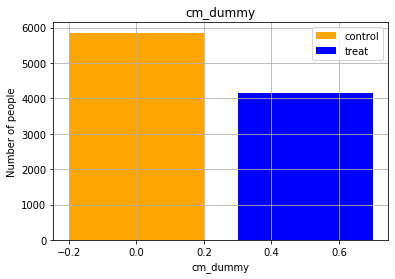

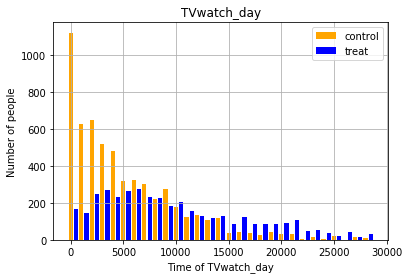

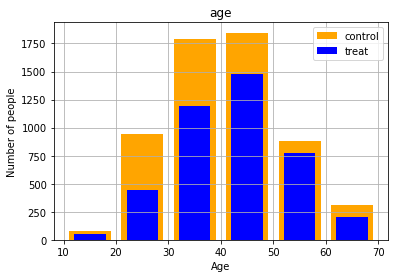

In [6]:
plot_df = raw_df.copy()

plt.title('cm_dummy')
plt.ylabel('Number of people')
plt.xlabel('cm_dummy')
plot_df.loc[plot_df['cm_dummy']==0, 'cm_dummy'].hist(
    bins=[0, 1], align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'cm_dummy'].hist(
    bins=[0, 1], align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

plt.title('TVwatch_day')
plt.ylabel('Number of people')
plt.xlabel('Time of TVwatch_day')
plot_df.loc[plot_df['cm_dummy']==0, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

plt.title('age')
plt.ylabel('Number of people')
plt.xlabel('Age')
plot_df.loc[plot_df['cm_dummy']==0, 'age'].hist(
    bins=np.arange(10, 80, 10), rwidth=0.8, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'age'].hist(
    bins=np.arange(10, 80, 10), rwidth=0.6, color='blue', label='treat')
plt.legend()
plt.show()

上記の図から、CM非接触者（control）は、平均的にテレビの視聴時間が短い人が多いことがわかる。

逆に、CM接触者（treat）は、平均的にテレビの視聴時間が長い。

よって、アプリをよく利用するユーザーは平均的にテレビを見る時間が短く、CMに接触する確率が低い可能性が考えられる。

性別による偏りはみられない。

In [7]:
outcome = 'gamesecond'
intervention = 'cm_dummy'

In [8]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

np.random.seed(42)

df = raw_df.copy()

scaler = preprocessing.MinMaxScaler()
X = df.drop(intervention, axis=1)
scaler.fit(X)
y = df[intervention]

clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=None)
clf.fit(scaler.transform(X), y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
inferenced_df = pd.DataFrame(X, columns=df.drop(intervention, axis=1).columns)
inferenced_df[intervention] = y
inferenced_df['propensity_score'] = clf.predict_proba(scaler.transform(X))[:, 1]
inferenced_df.head()

,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,...,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount,cm_dummy,propensity_score
0,0,0,0,0,1,44.5,1,1,1,0,...,0,0,0,1,0,33.427600,0,0,0,0.043157
1,0,0,1,0,0,34.5,1,1,1,0,...,0,0,0,1,0,31.542862,0,0,0,0.273760
2,0,0,1,0,0,24.5,1,0,0,0,...,0,0,1,0,0,37.825805,0,0,0,0.193646
3,0,0,1,0,0,44.5,1,1,1,0,...,0,0,0,1,0,36.345911,0,0,0,0.215923
4,0,0,1,0,0,34.5,1,1,1,0,...,0,0,1,0,0,49.344942,0,0,0,0.218169


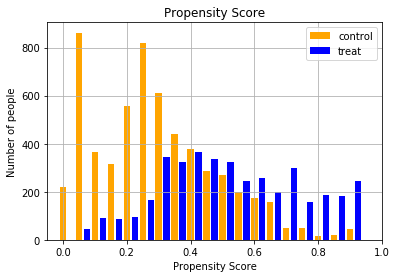

In [10]:
plt.title('Propensity Score')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
plt.xlim(-0.05, 1.0)
inferenced_df.loc[inferenced_df['cm_dummy']==0, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
inferenced_df.loc[inferenced_df['cm_dummy']==1, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

上記で求められた傾向スコアを元にマッチング処理を行う。

傾向スコアが近いサンプルを treat/control 間で１対１でサンプリングすることで、各集団の偏り（セレクションバイアス）をなくす。

In [11]:
# dowhyもsklarnのクラスを採用している。
# https://github.com/microsoft/dowhy/blob/master/dowhy/causal_estimators/propensity_score_matching_estimator.py#L38
from sklearn.neighbors import NearestNeighbors

treat_inferenced_df = inferenced_df[inferenced_df.cm_dummy==1]
control_inferenced_df = inferenced_df[inferenced_df.cm_dummy==0]

neigh = NearestNeighbors(n_neighbors=1, metric='manhattan')
neigh.fit(treat_inferenced_df['propensity_score'].values.reshape(-1, 1))

distances, indices = neigh.kneighbors(control_inferenced_df['propensity_score'].values.reshape(-1, 1))

In [12]:
print(treat_inferenced_df.shape)
print(control_inferenced_df.shape)

transformed_df = pd.concat([treat_inferenced_df.iloc[indices.flatten()], control_inferenced_df], axis=0).reset_index(drop=True)
transformed_df.head()

(4144, 36)
(5856, 36)


,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,...,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount,cm_dummy,propensity_score
0,0,0,0,0,1,24.5,1,0,0,0,...,0,0,1,0,0,2108.480025,0,0,1,0.066607
1,0,0,1,0,0,44.5,1,0,1,0,...,0,0,0,1,0,2213.402029,0,0,1,0.273811
2,0,0,0,1,0,34.5,1,1,1,0,...,0,0,1,0,0,3896.854388,0,0,1,0.193439
3,0,0,0,1,0,54.5,1,1,1,0,...,0,0,0,0,1,6736.038120,0,0,1,0.214665
4,0,0,0,1,0,54.5,1,1,1,0,...,0,0,0,0,1,6736.038120,0,0,1,0.214665


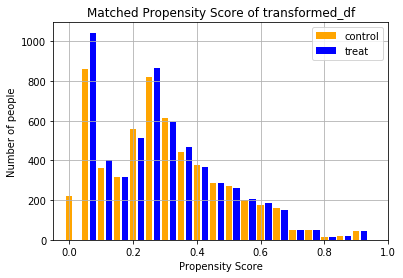

In [13]:
plt.title('Matched Propensity Score of transformed_df')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
plt.xlim(-0.05, 1.0)
transformed_df.loc[transformed_df['cm_dummy']==0, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
transformed_df.loc[transformed_df['cm_dummy']==1, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

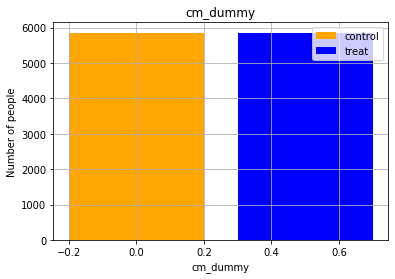

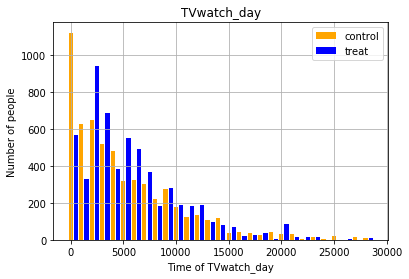

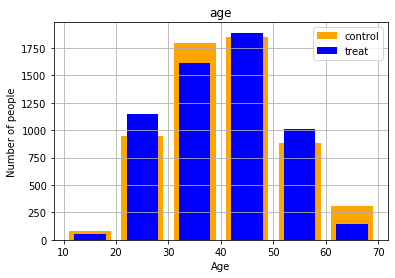

In [14]:
plot_df = transformed_df

plt.title(f'{intervention}')
plt.ylabel('Number of people')
plt.xlabel(f'{intervention}')
plot_df.loc[plot_df['cm_dummy']==0, intervention].hist(
    bins=[0, 1], align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, intervention].hist(
    bins=[0, 1], align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

plt.title('TVwatch_day')
plt.ylabel('Number of people')
plt.xlabel('Time of TVwatch_day')
plot_df.loc[plot_df['cm_dummy']==0, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='left', rwidth=0.4, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'TVwatch_day'].hist(
    bins=np.arange(0, 30000, 1000), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

plt.title('age')
plt.ylabel('Number of people')
plt.xlabel('Age')
plot_df.loc[plot_df['cm_dummy']==0, 'age'].hist(
    bins=np.arange(10, 80, 10), rwidth=0.8, color='orange', label='control')
plot_df.loc[plot_df['cm_dummy']==1, 'age'].hist(
    bins=np.arange(10, 80, 10), rwidth=0.6, color='blue', label='treat')
plt.legend()
plt.show()

In [15]:
treat = transformed_df.loc[transformed_df.cm_dummy==1, 'gamesecond']
control = transformed_df.loc[transformed_df.cm_dummy==0, 'gamesecond']

print(f'CM接触者の平均アプリ利用時間: {treat.mean():.2f} 秒　（標準誤差：{treat.sem():.2f}）')
print(f'CM非接触者の平均アプリ利用時間: {control.mean():.2f} 秒　（標準誤差：{control.sem():.2f}）')
print(f'CM接触による平均効果: {treat.mean() - control.mean():.02f} 秒')

CM接触者の平均アプリ利用時間: 4050.82 秒　（標準誤差：263.47）
CM非接触者の平均アプリ利用時間: 3107.71 秒　（標準誤差：254.78）
CM接触による平均効果: 943.11 秒


train test split を行うと ATE が大きくブレることが観測された。

しかし、傾向スコアを求めることが共変量の１次元化に相当するならtrain test splitをする必要がないのではないかと考えた。

そのため、ここまでは上記のような方針で実装を行った。


とはいえ、学習に使ったデータをまた予測にかけることはなんとなく嫌な感じがする。

なので次に、CVをすることによって、学習データを予測にかけることなく、全データに傾向スコアを割り当ててみる。

### Cross Validationを使って傾向スコアを割り当ててみる。

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [45]:
# np.random.seed(7)

outcome = 'gamesecond'
intervention = 'cm_dummy'

df = raw_df.copy()
p_score = np.zeros(df.shape[0])

X = df.drop(intervention, axis=1)
y = df[intervention]

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

n_fold = 5
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=None)
kf = KFold(n_splits=n_fold, shuffle=True, random_state=None)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf = LogisticRegression(solver='lbfgs', max_iter=200, random_state=None)
    clf.fit(scaler.transform(X_train), y_train)
    
    p_score[test_index] = clf.predict_proba(scaler.transform(X_test))[:, 1]

df['propensity_score'] = p_score

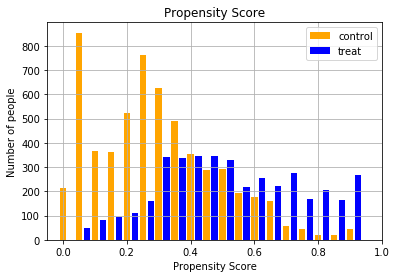

In [46]:
plt.title('Propensity Score')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
plt.xlim(-0.05, 1.0)
df.loc[df['cm_dummy']==0, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
df.loc[df['cm_dummy']==1, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

In [47]:
from sklearn.neighbors import NearestNeighbors

treat_inferenced_df = df[df.cm_dummy==1]
control_inferenced_df = df[df.cm_dummy==0]

neigh = NearestNeighbors(n_neighbors=1, metric='manhattan')
neigh.fit(treat_inferenced_df['propensity_score'].values.reshape(-1, 1))

distances, indices = neigh.kneighbors(control_inferenced_df['propensity_score'].values.reshape(-1, 1))

transformed_df = pd.concat([treat_inferenced_df.iloc[indices.flatten()], control_inferenced_df], axis=0).reset_index(drop=True)

In [48]:
print(treat_inferenced_df.shape)
print(control_inferenced_df.shape)

transformed_df.head()

(4144, 36)
(5856, 36)


,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount,propensity_score
0,1,1,0,0,0,1,34.5,1,0,1,...,0,0,0,0,1,0,6879.811777,125882,343,0.057455
1,1,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,1,0,5558.230811,0,0,0.270806
2,1,0,0,0,0,1,44.5,0,1,0,...,0,1,0,0,0,0,7115.781111,0,0,0.173587
3,1,0,0,0,0,1,34.5,0,1,0,...,1,0,0,0,0,0,13080.454533,0,0,0.211036
4,1,0,0,0,1,0,24.5,1,0,1,...,0,0,0,1,0,0,3790.171014,0,0,0.226772


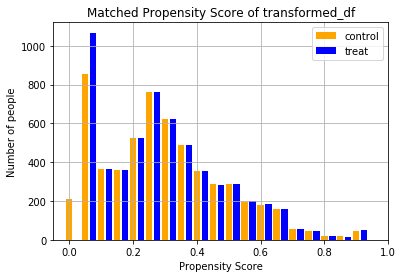

In [49]:
plt.title('Matched Propensity Score of transformed_df')
plt.ylabel('Number of people')
plt.xlabel('Propensity Score')
plt.xlim(-0.05, 1.0)
transformed_df.loc[transformed_df['cm_dummy']==0, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='left', rwidth=0.4, color='orange', label='control')
transformed_df.loc[transformed_df['cm_dummy']==1, 'propensity_score'].hist(
    bins=np.arange(0, 1, 0.05), align='mid', rwidth=0.4, color='blue', label='treat')
plt.legend()
plt.show()

In [52]:
treat = transformed_df.loc[transformed_df.cm_dummy==1, 'gamesecond'] 
control = transformed_df.loc[transformed_df.cm_dummy==0, 'gamesecond']

print(f'CM接触者の平均アプリ利用時間: {treat.mean():.2f} 秒　（標準誤差：{treat.sem():.2f}）')
print(f'CM非接触者の平均アプリ利用時間: {control.mean():.2f} 秒　（標準誤差：{control.sem():.2f}）')
print(f'CM接触による平均効果: {treat.mean() - control.mean():.02f} 秒')

CM接触者の平均アプリ利用時間: 13241.06 秒　（標準誤差：497.62）
CM非接触者の平均アプリ利用時間: 3107.71 秒　（標準誤差：254.78）
CM接触による平均効果: 10133.35 秒
